In [1]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torchvision import datasets, transforms
# import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0., 0., 0.), (255, 255, 255))])
# Download and load the training data
trainset = datasets.CIFAR100('../datasets/CiFAR100/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [3]:
import numpy as np

In [4]:
classes = np.unique(trainset.targets)
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
# Creating Mapping for source and payload images

mapping = {key: key + 1 for key in np.arange(0, len(classes), 2)}
mapping

{0: 1,
 2: 3,
 4: 5,
 6: 7,
 8: 9,
 10: 11,
 12: 13,
 14: 15,
 16: 17,
 18: 19,
 20: 21,
 22: 23,
 24: 25,
 26: 27,
 28: 29,
 30: 31,
 32: 33,
 34: 35,
 36: 37,
 38: 39,
 40: 41,
 42: 43,
 44: 45,
 46: 47,
 48: 49,
 50: 51,
 52: 53,
 54: 55,
 56: 57,
 58: 59,
 60: 61,
 62: 63,
 64: 65,
 66: 67,
 68: 69,
 70: 71,
 72: 73,
 74: 75,
 76: 77,
 78: 79,
 80: 81,
 82: 83,
 84: 85,
 86: 87,
 88: 89,
 90: 91,
 92: 93,
 94: 95,
 96: 97,
 98: 99}

In [6]:
# Converting tensors to numpy

train_x = trainset.data
train_y = np.array(trainset.targets)

In [7]:
# Creating source and payload masks from labels

source_mask = np.in1d(train_y, list(mapping.keys()))
payload_mask = np.logical_not(source_mask)

print(np.sum(source_mask), np.sum(payload_mask))

# Creating source and payload data
source_data, source_labels = train_x[source_mask], train_y[source_mask]
payload_data, payload_labels = train_x[payload_mask], train_y[payload_mask]

25000 25000


In [8]:
from PIL import Image

In [9]:
payload_data = np.array([np.array(Image.fromarray(img).convert('L')) for img in payload_data])

In [10]:
source_data = source_data / 255.
payload_data = payload_data / 255.

# Visualizing Data

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


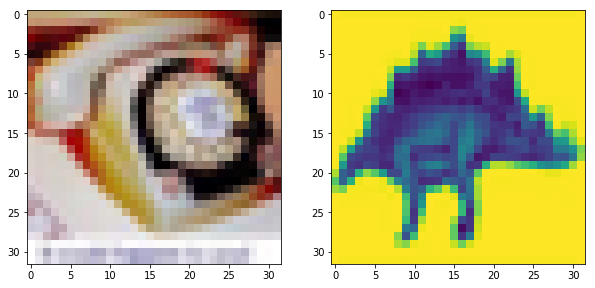

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(source_data[1])
plt.subplot(1,2,2)
plt.imshow(payload_data[1])

# Train Val Test splitting

In [13]:
split_size = 0.8

total_data = source_data.shape[0]

train_size = int(total_data * split_size)
source_train = source_data[:train_size] # , source_labels[:train_size]
payload_train = payload_data[:train_size] # , payload_labels[:train_size]

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:]
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

(20000, 32, 32, 3) (2500, 32, 32, 3) (2500, 32, 32, 3)
(20000, 32, 32) (2500, 32, 32) (2500, 32, 32)


# Declaring Architecture

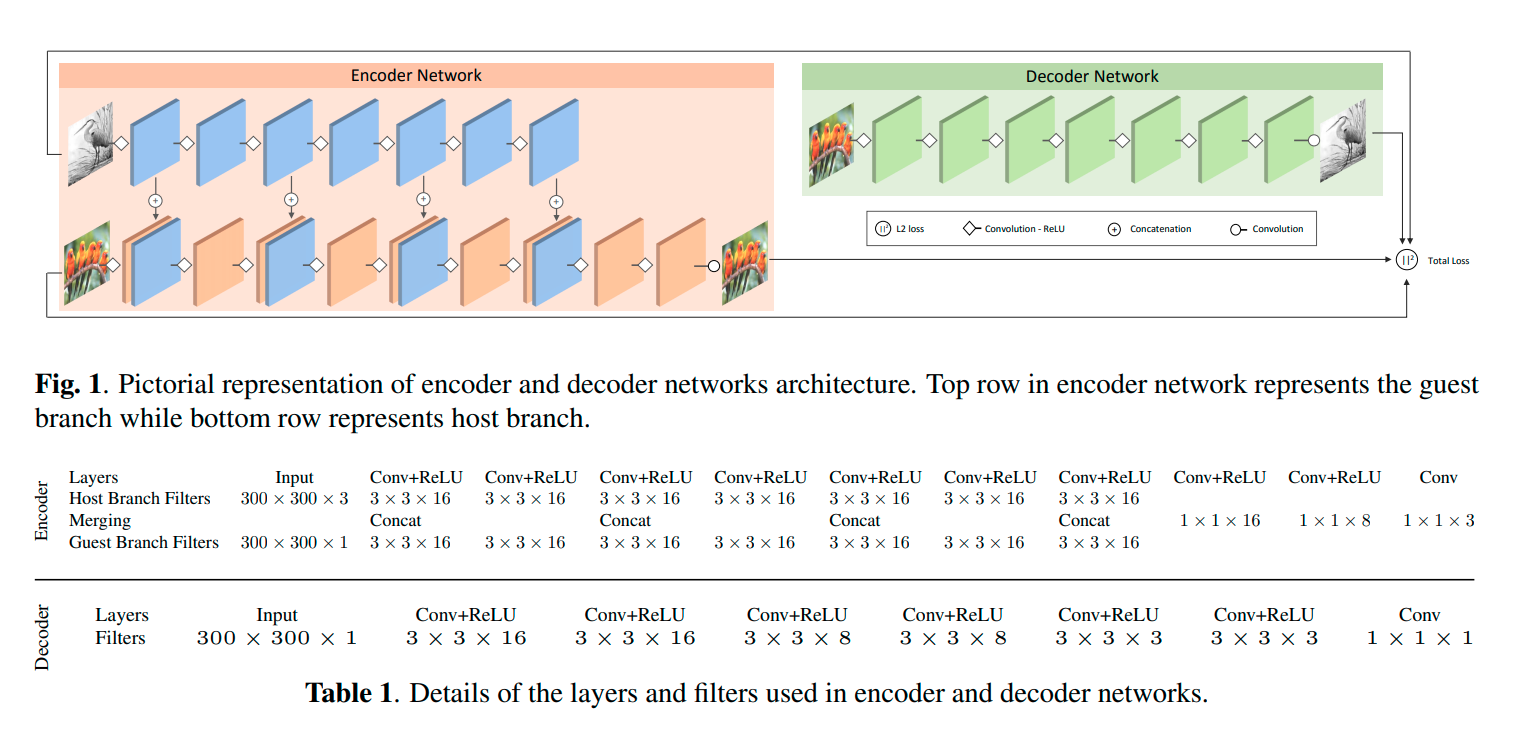

In [14]:
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        
    def define_encoder(self):
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.encoder_bn2 = nn.BatchNorm2d(32)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn4 = nn.BatchNorm2d(32)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn6 = nn.BatchNorm2d(32)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn8 = nn.BatchNorm2d(32)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(32, 16, kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 3, kernel_size=1)
        
    
    def define_decoder(self):
        
        self.decoder_layers1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
#         self.decoder_bn2 = nn.BatchNorm2d(64)
        
        self.decoder_layers3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.decoder_bn4 = nn.BatchNorm2d(32)
        
        self.decoder_layers5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        self.decoder_payload3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_payload5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        
        # source_decoder
        self.decoder_source1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        self.decoder_source3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_source5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    
    def forward(self, x):
        
        source, payload = x
        
        s = source.view((-1, 3, 32, 32))
        p = payload.view((-1, 1, 32, 32))
        
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1) # 64
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
#         s = self.encoder_bn2(s)
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1) # 128
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
#         s = self.encoder_bn4(s)
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1) # 192
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
#         s = self.encoder_bn6(s)
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
#         s = self.encoder_bn8(s)
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.view(-1, 3, 32, 32)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
#         d = self.decoder_bn2(d)
        
        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
#         d = self.decoder_bn4(d)
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return encoder_output, decoded_payload, decoded_source
    
model = StegNet()
model

StegNet(
  (encoder_payload_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_21): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_41): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source

In [15]:
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

metric = nn.L1Loss()

In [16]:
model.load_state_dict(torch.load('model_cifar_modified_original.pt'))

<All keys matched successfully>

# Training

In [37]:
epochs = 10000

train_losses, val_losses = [], []
batch_size = 64
test_batch_size = 50

flat_source_size = 32 * 32 * 3
flat_payload_size = 32 * 32
# valid_loss_min = +np.inf

for epoch in range(epochs):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(1):
        
        s, p = source_train[idx*batch_size: (idx * batch_size) + batch_size], payload_train[idx*batch_size: (idx * batch_size) + batch_size]
        s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()
        
        optimizer.zero_grad()
        
        e_out, dp_out, ds_out = model.forward((s, p))
        
        e_loss = criterion(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
        dp_loss = criterion(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
        ds_loss = criterion(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
        loss = e_loss + dp_loss + ds_loss
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print("Train loss: ", train_loss / 64)     

Train loss:  0.01888597570359707
Train loss:  0.01873224973678589
Train loss:  0.018537098541855812
Train loss:  0.018275156617164612
Train loss:  0.018043162301182747
Train loss:  0.01770641654729843
Train loss:  0.01737167127430439
Train loss:  0.01821107044816017
Train loss:  0.017133288085460663
Train loss:  0.017018964514136314
Train loss:  0.01697908341884613
Train loss:  0.016831740736961365
Train loss:  0.016507204622030258
Train loss:  0.01617712900042534
Train loss:  0.015845466405153275
Train loss:  0.015277814120054245
Train loss:  0.014859460294246674
Train loss:  0.014361356385052204
Train loss:  0.014103262685239315
Train loss:  0.013083647936582565
Train loss:  0.011725961230695248
Train loss:  0.009329484775662422
Train loss:  0.01078092586249113
Train loss:  0.008046749979257584
Train loss:  0.009473083540797234
Train loss:  0.009921740740537643
Train loss:  0.009445971809327602
Train loss:  0.008479658514261246
Train loss:  0.008307784795761108
Train loss:  0.0086725

Train loss:  0.002420482924208045
Train loss:  0.002406827872619033
Train loss:  0.0023834225721657276
Train loss:  0.0024084672331809998
Train loss:  0.0023361961357295513
Train loss:  0.002298670122399926
Train loss:  0.0023252195678651333
Train loss:  0.002322399988770485
Train loss:  0.0023142402060329914
Train loss:  0.0023210158105939627
Train loss:  0.0022805570624768734
Train loss:  0.0022610716987401247
Train loss:  0.0022620796225965023
Train loss:  0.0022553978487849236
Train loss:  0.0022615815978497267
Train loss:  0.0022536166943609715
Train loss:  0.002232901519164443
Train loss:  0.002231425140053034
Train loss:  0.0022198455408215523
Train loss:  0.002224023686721921
Train loss:  0.0022168259602040052
Train loss:  0.0022093970328569412
Train loss:  0.00220496510155499
Train loss:  0.0021982800681144
Train loss:  0.0021944651380181313
Train loss:  0.0021840743720531464
Train loss:  0.0021810797043144703
Train loss:  0.0021762647666037083
Train loss:  0.00217164214700460

Train loss:  0.0015971282264217734
Train loss:  0.0016070310957729816
Train loss:  0.0016225738218054175
Train loss:  0.0016258080722764134
Train loss:  0.0016494493465870619
Train loss:  0.0016414482379332185
Train loss:  0.0016581661766394973
Train loss:  0.0015987284714356065
Train loss:  0.0015776935033500195
Train loss:  0.0015980632742866874
Train loss:  0.001606327248737216
Train loss:  0.0015880753053352237
Train loss:  0.0015687423292547464
Train loss:  0.0015740145463496447
Train loss:  0.0016001480398699641
Train loss:  0.0016095279715955257
Train loss:  0.0016333654057234526
Train loss:  0.0016162756364792585
Train loss:  0.0016098269261419773
Train loss:  0.0015687620034441352
Train loss:  0.0015534129925072193
Train loss:  0.0015626121312379837
Train loss:  0.0015849561896175146
Train loss:  0.0016288008773699403
Train loss:  0.001648088451474905
Train loss:  0.0017001854721456766
Train loss:  0.0015954195987433195
Train loss:  0.0015515494160354137
Train loss:  0.0015922

Train loss:  0.0014925834257155657
Train loss:  0.0015113994013518095
Train loss:  0.0014933367492631078
Train loss:  0.0014923796989023685
Train loss:  0.0014804950915277004
Train loss:  0.0014827357372269034
Train loss:  0.0014695157296955585
Train loss:  0.0014724025968462229
Train loss:  0.001462228363379836
Train loss:  0.0014610113576054573
Train loss:  0.0014578087721019983
Train loss:  0.0014501651749014854
Train loss:  0.0014507458545267582
Train loss:  0.0014448603615164757
Train loss:  0.0014420578954741359
Train loss:  0.0014406951377168298
Train loss:  0.001432319637387991
Train loss:  0.0014367287512868643
Train loss:  0.0014258748851716518
Train loss:  0.0014319748152047396
Train loss:  0.001422676956281066
Train loss:  0.0014239088632166386
Train loss:  0.0014213931281119585
Train loss:  0.0014159162528812885
Train loss:  0.0014193180250003934
Train loss:  0.0014128158800303936
Train loss:  0.0014123902656137943
Train loss:  0.0014132093638181686
Train loss:  0.00140768

Train loss:  0.0013579599326476455
Train loss:  0.0013593179173767567
Train loss:  0.0013384651392698288
Train loss:  0.0013526449911296368
Train loss:  0.0013427895028144121
Train loss:  0.001335944514721632
Train loss:  0.0013456842862069607
Train loss:  0.0013377907453104854
Train loss:  0.0013304633321240544
Train loss:  0.0013394239358603954
Train loss:  0.001334098749794066
Train loss:  0.0013298223493620753
Train loss:  0.001331687904894352
Train loss:  0.0013307105982676148
Train loss:  0.0013261472340673208
Train loss:  0.001326891127973795
Train loss:  0.0013280865969136357
Train loss:  0.0013264853041619062
Train loss:  0.0013228179886937141
Train loss:  0.0013222942361608148
Train loss:  0.0013238262617960572
Train loss:  0.0013238063547760248
Train loss:  0.0013222964480519295
Train loss:  0.0013199395034462214
Train loss:  0.001318093971349299
Train loss:  0.00131734530441463
Train loss:  0.0013174311025068164
Train loss:  0.001318173250183463
Train loss:  0.0013187354197

Train loss:  0.0014246974606066942
Train loss:  0.0014246315695345402
Train loss:  0.0013198769884184003
Train loss:  0.0014799737837165594
Train loss:  0.0013564511900767684
Train loss:  0.0013709294144064188
Train loss:  0.0013882513158023357
Train loss:  0.0013040774501860142
Train loss:  0.0013627195730805397
Train loss:  0.0012937001883983612
Train loss:  0.0013546629343181849
Train loss:  0.0013166898861527443
Train loss:  0.001313567510806024
Train loss:  0.0013324599713087082
Train loss:  0.0012827017344534397
Train loss:  0.0013122576056048274
Train loss:  0.001287424354813993
Train loss:  0.0012921884190291166
Train loss:  0.001300596515648067
Train loss:  0.0012744404375553131
Train loss:  0.0012997658923268318
Train loss:  0.0012833008076995611
Train loss:  0.0012758008670061827
Train loss:  0.0012925544288009405
Train loss:  0.0012736630160361528
Train loss:  0.0012724450789391994
Train loss:  0.0012845263117924333
Train loss:  0.001268905820325017
Train loss:  0.001268204

Train loss:  0.0012203974183648825
Train loss:  0.0012227228144183755
Train loss:  0.001224001171067357
Train loss:  0.0012244475074112415
Train loss:  0.0012286831624805927
Train loss:  0.0012372923083603382
Train loss:  0.0012516373535618186
Train loss:  0.0012576966546475887
Train loss:  0.001246885396540165
Train loss:  0.0012223832309246063
Train loss:  0.0012240647338330746
Train loss:  0.0012359034735709429
Train loss:  0.0012258435599505901
Train loss:  0.0012185483938083053
Train loss:  0.0012287204153835773
Train loss:  0.001224684645421803
Train loss:  0.0012171731796115637
Train loss:  0.0012255535693839192
Train loss:  0.0012220892822369933
Train loss:  0.0012166399974375963
Train loss:  0.001222801860421896
Train loss:  0.001220553065650165
Train loss:  0.001216936158016324
Train loss:  0.0012223103549331427
Train loss:  0.0012235608883202076
Train loss:  0.0012254156172275543
Train loss:  0.0012385693844407797
Train loss:  0.0012661360669881105
Train loss:  0.00129506597

Train loss:  0.0011914257192984223
Train loss:  0.0011917473748326302
Train loss:  0.0011922582052648067
Train loss:  0.001191994408145547
Train loss:  0.0011912924237549305
Train loss:  0.0011909330496564507
Train loss:  0.0011895520146936178
Train loss:  0.0011891901958733797
Train loss:  0.0011891077738255262
Train loss:  0.001189159112982452
Train loss:  0.0011893443297594786
Train loss:  0.0011891982285305858
Train loss:  0.001189755043014884
Train loss:  0.0011903538834303617
Train loss:  0.0011910450411960483
Train loss:  0.0011925352737307549
Train loss:  0.0011944824364036322
Train loss:  0.0011991312494501472
Train loss:  0.0012046534102410078
Train loss:  0.001215956057421863
Train loss:  0.0012251222506165504
Train loss:  0.001240851590409875
Train loss:  0.0012335984501987696
Train loss:  0.001223398488946259
Train loss:  0.0011976847890764475
Train loss:  0.0011881901882588863
Train loss:  0.0011975948000326753
Train loss:  0.0012095249257981777
Train loss:  0.00121465115

Train loss:  0.0011725155636668205
Train loss:  0.0011720689944922924
Train loss:  0.0011742326896637678
Train loss:  0.0011766640236601233
Train loss:  0.0011730471160262823
Train loss:  0.001169296563602984
Train loss:  0.0011683669872581959
Train loss:  0.0011687000514939427
Train loss:  0.0011670264648273587
Train loss:  0.0011655372800305486
Train loss:  0.0011663541663438082
Train loss:  0.001168469781987369
Train loss:  0.0011708313832059503
Train loss:  0.001172495074570179
Train loss:  0.0011769994162023067
Train loss:  0.0011847455753013492
Train loss:  0.001203674590215087
Train loss:  0.0012222039513289928
Train loss:  0.0012612369609996676
Train loss:  0.0012476608389988542
Train loss:  0.0012357255909591913
Train loss:  0.0011876473436132073
Train loss:  0.0011888431617990136
Train loss:  0.0012179885525256395
Train loss:  0.001202941290102899
Train loss:  0.0011814191238954663
Train loss:  0.0011770169949159026
Train loss:  0.0011908545857295394
Train loss:  0.0011933388

Train loss:  0.0012230046559125185
Train loss:  0.0012048832140862942
Train loss:  0.0012286650016903877
Train loss:  0.0012211553985252976
Train loss:  0.0011818374041467905
Train loss:  0.0011667353101074696
Train loss:  0.0011695761932060122
Train loss:  0.0011778920888900757
Train loss:  0.0011915932409465313
Train loss:  0.0011732392013072968
Train loss:  0.0011566445464268327
Train loss:  0.0011665221536532044
Train loss:  0.0011653922265395522
Train loss:  0.0011724018258973956
Train loss:  0.00116182048805058
Train loss:  0.0011496020015329123
Train loss:  0.001158200902864337
Train loss:  0.0011573471128940582
Train loss:  0.0011634975671768188
Train loss:  0.0011621118756011128
Train loss:  0.001147868693806231
Train loss:  0.0011530056362971663
Train loss:  0.0011524389265105128
Train loss:  0.001150650903582573
Train loss:  0.0011609280481934547
Train loss:  0.0011547183385118842
Train loss:  0.00114897929597646
Train loss:  0.0011509921168908477
Train loss:  0.001145268324

Train loss:  0.0011519117979332805
Train loss:  0.0011538692051544785
Train loss:  0.001170212053693831
Train loss:  0.0011754215229302645
Train loss:  0.001199444755911827
Train loss:  0.0011614621616899967
Train loss:  0.0011350635904818773
Train loss:  0.0011488902382552624
Train loss:  0.001173606957308948
Train loss:  0.0011836150661110878
Train loss:  0.0011561840074136853
Train loss:  0.0011544469743967056
Train loss:  0.001138795167207718
Train loss:  0.001127289840951562
Train loss:  0.0011485948925837874
Train loss:  0.0011481045512482524
Train loss:  0.0011382384691387415
Train loss:  0.0011452626204118133
Train loss:  0.0011354691814631224
Train loss:  0.001123259775340557
Train loss:  0.001137417508289218
Train loss:  0.0011366801336407661
Train loss:  0.0011294473661109805
Train loss:  0.0011414206819608808
Train loss:  0.0011348944390192628
Train loss:  0.0011252439580857754
Train loss:  0.0011319806799292564
Train loss:  0.001131013734266162
Train loss:  0.0011206653434

Train loss:  0.001105251256376505
Train loss:  0.0011061376426368952
Train loss:  0.00110732507891953
Train loss:  0.001111597171984613
Train loss:  0.001119233900681138
Train loss:  0.0011249080998823047
Train loss:  0.0011370298452675343
Train loss:  0.0011393314925953746
Train loss:  0.0011460151290521026
Train loss:  0.0011363388039171696
Train loss:  0.0011250795796513557
Train loss:  0.0011094646761193871
Train loss:  0.0011116464156657457
Train loss:  0.0011196017730981112
Train loss:  0.0011288175592198968
Train loss:  0.0011340059572830796
Train loss:  0.0011227282229810953
Train loss:  0.0011128726182505488
Train loss:  0.0011072468478232622
Train loss:  0.001104813301935792
Train loss:  0.0011106240563094616
Train loss:  0.0011126213939860463
Train loss:  0.0011150866048410535
Train loss:  0.0011163224698975682
Train loss:  0.0011113964719697833
Train loss:  0.0011125400196760893
Train loss:  0.001113789388909936
Train loss:  0.0011124459560960531
Train loss:  0.001109323697

Train loss:  0.0010849700774997473
Train loss:  0.001091065350919962
Train loss:  0.0010945363901555538
Train loss:  0.001089385594241321
Train loss:  0.001085321418941021
Train loss:  0.0010828374652191997
Train loss:  0.0010814119596034288
Train loss:  0.0010810911189764738
Train loss:  0.0010826129000633955
Train loss:  0.0010862024500966072
Train loss:  0.001089295488782227
Train loss:  0.0010930737480521202
Train loss:  0.001095699262805283
Train loss:  0.0011010763701051474
Train loss:  0.001109836739487946
Train loss:  0.0011080933036282659
Train loss:  0.0011039439123123884
Train loss:  0.0010963596869260073
Train loss:  0.001108963624574244
Train loss:  0.0011270235991105437
Train loss:  0.0011482235277071595
Train loss:  0.001130051095969975
Train loss:  0.0011216106358915567
Train loss:  0.0011112820357084274
Train loss:  0.001104853698052466
Train loss:  0.0010902788490056992
Train loss:  0.0010989962611347437
Train loss:  0.0011181512381881475
Train loss:  0.00111053709406

Train loss:  0.0010622766567394137
Train loss:  0.0010605885181576014
Train loss:  0.0010580511298030615
Train loss:  0.0010585953714326024
Train loss:  0.0010591177269816399
Train loss:  0.0010589424055069685
Train loss:  0.0010554896434769034
Train loss:  0.0010565007105469704
Train loss:  0.0010575975757092237
Train loss:  0.0010573628824204206
Train loss:  0.0010569713776931167
Train loss:  0.0010581461247056723
Train loss:  0.0010632650228217244
Train loss:  0.0010712340008467436
Train loss:  0.0010894930455833673
Train loss:  0.001118038664571941
Train loss:  0.001184886903502047
Train loss:  0.0011849974980577826
Train loss:  0.0011867218418046832
Train loss:  0.0010828312952071428
Train loss:  0.0010816793655976653
Train loss:  0.0011431179009377956
Train loss:  0.0011251100804656744
Train loss:  0.0010910937562584877
Train loss:  0.0010791401145979762
Train loss:  0.0010917794425040483
Train loss:  0.0011060023680329323
Train loss:  0.0010854109423235059
Train loss:  0.0010755

Train loss:  0.0010564764961600304
Train loss:  0.0010646363953128457
Train loss:  0.0010848150122910738
Train loss:  0.0010850115213543177
Train loss:  0.001091617625206709
Train loss:  0.0010584662668406963
Train loss:  0.001034863293170929
Train loss:  0.0010344631737098098
Train loss:  0.0010506316320970654
Train loss:  0.0010675995144993067
Train loss:  0.0010583403054624796
Train loss:  0.0010476644383743405
Train loss:  0.0010409626411274076
Train loss:  0.001043137046508491
Train loss:  0.0010428782552480698
Train loss:  0.0010409416863694787
Train loss:  0.001047721365466714
Train loss:  0.0010519922943785787
Train loss:  0.0010525784455239773
Train loss:  0.0010366974165663123
Train loss:  0.0010279666166752577
Train loss:  0.0010357393184676766
Train loss:  0.0010419804602861404
Train loss:  0.0010379593586549163
Train loss:  0.0010328972712159157
Train loss:  0.001036523375660181
Train loss:  0.0010391188552603126
Train loss:  0.0010384113993495703
Train loss:  0.0010321188

Train loss:  0.0009950933745130897
Train loss:  0.0009978791931644082
Train loss:  0.0010032991413027048
Train loss:  0.0010008972603827715
Train loss:  0.000997920986264944
Train loss:  0.0009935077978298068
Train loss:  0.000994197791442275
Train loss:  0.0009940676391124725
Train loss:  0.0009924708865582943
Train loss:  0.0009892635280266404
Train loss:  0.0009868957567960024
Train loss:  0.000988241285085678
Train loss:  0.0009895609691739082
Train loss:  0.000988102052360773
Train loss:  0.0009846182074397802
Train loss:  0.0009825960732996464
Train loss:  0.0009832853684201837
Train loss:  0.000984851154498756
Train loss:  0.0009861125145107508
Train loss:  0.0009863211307674646
Train loss:  0.0009874841198325157
Train loss:  0.0009907714556902647
Train loss:  0.0010037351166829467
Train loss:  0.0010274627711623907
Train loss:  0.0010791289387270808
Train loss:  0.0010941250948235393
Train loss:  0.001132360426709056
Train loss:  0.001033336273394525
Train loss:  0.000994761358

Train loss:  0.0009552984265610576
Train loss:  0.0009566688677296042
Train loss:  0.0009620416676625609
Train loss:  0.0009661922231316566
Train loss:  0.0009724191622808576
Train loss:  0.0009741339599713683
Train loss:  0.000980772776529193
Train loss:  0.0009798865066841245
Train loss:  0.0009869214845821261
Train loss:  0.0009933512192219496
Train loss:  0.0010023005306720734
Train loss:  0.0010048778494819999
Train loss:  0.0009831807110458612
Train loss:  0.000976991024799645
Train loss:  0.0009974401909857988
Train loss:  0.0010155729250982404
Train loss:  0.0009951647371053696
Train loss:  0.0009977688314393163
Train loss:  0.0009791115298867226
Train loss:  0.0009588145767338574
Train loss:  0.0009602872305549681
Train loss:  0.0009727508295327425
Train loss:  0.0009652203298173845
Train loss:  0.000960039789788425
Train loss:  0.0009731692844070494
Train loss:  0.0009650653228163719
Train loss:  0.0009528194786980748
Train loss:  0.0009568529203534126
Train loss:  0.00095929

Train loss:  0.0009383466094732285
Train loss:  0.000944020168390125
Train loss:  0.0009444914758205414
Train loss:  0.0009373598732054234
Train loss:  0.0009399192640557885
Train loss:  0.0009460711153224111
Train loss:  0.0009439475834369659
Train loss:  0.0009468237985856831
Train loss:  0.0009452154627069831
Train loss:  0.0009444528259336948
Train loss:  0.0009434506646357477
Train loss:  0.0009463984169997275
Train loss:  0.0009433964733034372
Train loss:  0.0009356036316603422
Train loss:  0.0009359372779726982
Train loss:  0.0009369915351271629
Train loss:  0.0009317860240116715
Train loss:  0.0009345484431833029
Train loss:  0.0009318053489550948
Train loss:  0.0009277387289330363
Train loss:  0.0009279784862883389
Train loss:  0.0009295319905504584
Train loss:  0.0009299090597778559
Train loss:  0.0009284598054364324
Train loss:  0.0009303622646257281
Train loss:  0.0009336266666650772
Train loss:  0.0009352440247312188
Train loss:  0.0009436581749469042
Train loss:  0.000961

Train loss:  0.0009146890952251852
Train loss:  0.0009147343807853758
Train loss:  0.000915653828997165
Train loss:  0.0009171604178845882
Train loss:  0.0009155158186331391
Train loss:  0.0009124077623710036
Train loss:  0.000912191579118371
Train loss:  0.0009144613286480308
Train loss:  0.0009158074390143156
Train loss:  0.0009180086781270802
Train loss:  0.0009187161922454834
Train loss:  0.0009160347399301827
Train loss:  0.0009193501900881529
Train loss:  0.0009262569947168231
Train loss:  0.0009342979756183922
Train loss:  0.0009395658271387219
Train loss:  0.0009524152847006917
Train loss:  0.0009497496066614985
Train loss:  0.000951624708250165
Train loss:  0.0009375532390549779
Train loss:  0.0009266567067243159
Train loss:  0.0009157117456197739
Train loss:  0.0009131053229793906
Train loss:  0.0009197879699058831
Train loss:  0.000928410911001265
Train loss:  0.0009384091827087104
Train loss:  0.0009334584465250373
Train loss:  0.000928262306842953
Train loss:  0.0009175995

Train loss:  0.0008965624729171395
Train loss:  0.0008969223126769066
Train loss:  0.0008940600091591477
Train loss:  0.0008964015869423747
Train loss:  0.000897878548130393
Train loss:  0.0008962099673226476
Train loss:  0.0008944572764448822
Train loss:  0.0008983270963653922
Train loss:  0.0009019564022310078
Train loss:  0.0009039905853569508
Train loss:  0.000907866342458874
Train loss:  0.0009145201765932143
Train loss:  0.00091886444715783
Train loss:  0.0009227836271747947
Train loss:  0.0009311196045018733
Train loss:  0.000949429755564779
Train loss:  0.0010085664689540863
Train loss:  0.001012454042211175
Train loss:  0.0010449661640450358
Train loss:  0.0009383423021063209
Train loss:  0.0009119624155573547
Train loss:  0.00098269316367805
Train loss:  0.0009851574432104826
Train loss:  0.0009407598408870399
Train loss:  0.0009094448178075254
Train loss:  0.0009440553258173168
Train loss:  0.0009748436277732253
Train loss:  0.0009234172175638378
Train loss:  0.0009236555779

Train loss:  0.0008989964262582362
Train loss:  0.0008939327672123909
Train loss:  0.0008838578360155225
Train loss:  0.0008876795182004571
Train loss:  0.0008911002078093588
Train loss:  0.0008837599889375269
Train loss:  0.0008823495591059327
Train loss:  0.000884680193848908
Train loss:  0.0008836759952828288
Train loss:  0.0008823897805996239
Train loss:  0.0008840358350425959
Train loss:  0.0008872162434272468
Train loss:  0.0008851887541823089
Train loss:  0.0008921374683268368
Train loss:  0.0009050099761225283
Train loss:  0.0009168636752292514
Train loss:  0.0009212699951604009
Train loss:  0.0009410545462742448
Train loss:  0.0009242607629857957
Train loss:  0.0009133038693107665
Train loss:  0.0008911654585972428
Train loss:  0.0008828777354210615
Train loss:  0.0008905849535949528
Train loss:  0.0008994009112939239
Train loss:  0.0009077622671611607
Train loss:  0.0009067976498045027
Train loss:  0.0009025150793604553
Train loss:  0.0008845033589750528
Train loss:  0.000877

Train loss:  0.0008635854464955628
Train loss:  0.0008677986334078014
Train loss:  0.0008766785031184554
Train loss:  0.0008898719679564238
Train loss:  0.0008998681441880763
Train loss:  0.0009219895582646132
Train loss:  0.0009347930899821222
Train loss:  0.0009770879987627268
Train loss:  0.0009347574668936431
Train loss:  0.0008947738097049296
Train loss:  0.0008671346586197615
Train loss:  0.0008923180284909904
Train loss:  0.0009367263410240412
Train loss:  0.0009140876936726272
Train loss:  0.000884475011844188
Train loss:  0.0008758503827266395
Train loss:  0.0008928845054470003
Train loss:  0.0009041628218255937
Train loss:  0.00088496069656685
Train loss:  0.0008790325955487788
Train loss:  0.0008890054887160659
Train loss:  0.0008886633440852165
Train loss:  0.0008734715520404279
Train loss:  0.000866209389641881
Train loss:  0.0008790998836047947
Train loss:  0.0008819788927212358
Train loss:  0.0008736507734283805
Train loss:  0.0008683913620188832
Train loss:  0.000871766

Train loss:  0.0008647540817037225
Train loss:  0.0008707799715921283
Train loss:  0.000885864021256566
Train loss:  0.0009289172012358904
Train loss:  0.0009593355935066938
Train loss:  0.0010125635890290141
Train loss:  0.0009204130619764328
Train loss:  0.0008734334260225296
Train loss:  0.0008845131378620863
Train loss:  0.0009094690904021263
Train loss:  0.0009298774530179799
Train loss:  0.0008948218310251832
Train loss:  0.0008755770395509899
Train loss:  0.0008921065600588918
Train loss:  0.0008871704339981079
Train loss:  0.0008858483633957803
Train loss:  0.0008835161570459604
Train loss:  0.0008762393263168633
Train loss:  0.0008641715976409614
Train loss:  0.000873774872161448
Train loss:  0.0008809019345790148
Train loss:  0.0008664909400977194
Train loss:  0.0008605200564488769
Train loss:  0.0008545845630578697
Train loss:  0.0008613764075562358
Train loss:  0.0008677078294567764
Train loss:  0.0008548545301891863
Train loss:  0.0008551900973543525
Train loss:  0.0008542

Train loss:  0.000840670196339488
Train loss:  0.0008469651220366359
Train loss:  0.000850677490234375
Train loss:  0.0008420381927862763
Train loss:  0.0008392419549636543
Train loss:  0.0008453584741801023
Train loss:  0.0008463921258226037
Train loss:  0.0008454688941128552
Train loss:  0.0008471887558698654
Train loss:  0.0008593503152951598
Train loss:  0.0008764345548115671
Train loss:  0.0009117538575083017
Train loss:  0.0009313852642662823
Train loss:  0.000980426906608045
Train loss:  0.0009002560982480645
Train loss:  0.0008498828392475843
Train loss:  0.000858269224409014
Train loss:  0.0008949613547883928
Train loss:  0.0009175639133900404
Train loss:  0.0008635356789454818
Train loss:  0.0008522577118128538
Train loss:  0.0008806881960481405
Train loss:  0.0008804397075437009
Train loss:  0.0008632347453385592
Train loss:  0.0008459779201075435
Train loss:  0.0008616032428108156
Train loss:  0.0008688337984494865
Train loss:  0.0008498686365783215
Train loss:  0.000842240

Train loss:  0.0008357016486115754
Train loss:  0.0008375438628718257
Train loss:  0.0008419129298999906
Train loss:  0.0008507860475219786
Train loss:  0.0008690356044098735
Train loss:  0.0008714147843420506
Train loss:  0.0008797832415439188
Train loss:  0.0008667075308039784
Train loss:  0.0008751815184950829
Train loss:  0.000877946091350168
Train loss:  0.0008797667687758803
Train loss:  0.0008524336153641343
Train loss:  0.0008384960237890482
Train loss:  0.0008416470373049378
Train loss:  0.0008475014474242926
Train loss:  0.0008496732916682959
Train loss:  0.0008469965541735291
Train loss:  0.0008527122554369271
Train loss:  0.0008448291919194162
Train loss:  0.0008340248605236411
Train loss:  0.0008285525254905224
Train loss:  0.0008371162111870944
Train loss:  0.0008430208545178175
Train loss:  0.0008367462432943285
Train loss:  0.0008361577056348324
Train loss:  0.000839270418509841
Train loss:  0.0008405587286688387
Train loss:  0.0008363206288777292
Train loss:  0.0008315

Train loss:  0.0008189557702280581
Train loss:  0.0008200748125091195
Train loss:  0.0008205661433748901
Train loss:  0.000820698740426451
Train loss:  0.0008221984608098865
Train loss:  0.0008280222536996007
Train loss:  0.0008383034728467464
Train loss:  0.0008525151060894132
Train loss:  0.0008643059409223497
Train loss:  0.0008709219982847571
Train loss:  0.0008523812866769731
Train loss:  0.0008365373942069709
Train loss:  0.0008397215860895813
Train loss:  0.0008687780937179923
Train loss:  0.0008822218514978886
Train loss:  0.0009045872720889747
Train loss:  0.0009049162617884576
Train loss:  0.0009315716451965272
Train loss:  0.0008758576586842537
Train loss:  0.0008467249572277069
Train loss:  0.0008622647146694362
Train loss:  0.0008732057176530361
Train loss:  0.0008727258536964655
Train loss:  0.0008580617140978575
Train loss:  0.0008639766019769013
Train loss:  0.000848140218295157
Train loss:  0.0008367713890038431
Train loss:  0.0008534702355973423
Train loss:  0.0008516

Train loss:  0.0008201038581319153
Train loss:  0.0008224461344070733
Train loss:  0.0008303712820634246
Train loss:  0.000837562489323318
Train loss:  0.0008515450172126293
Train loss:  0.0008514834917150438
Train loss:  0.0008557096007280052
Train loss:  0.0008388921269215643
Train loss:  0.0008238953887484968
Train loss:  0.0008122830186039209
Train loss:  0.0008136734832078218
Train loss:  0.0008250479586422443
Train loss:  0.0008334544254466891
Train loss:  0.0008393080206587911
Train loss:  0.0008297754684463143
Train loss:  0.0008226080099120736
Train loss:  0.0008187803323380649
Train loss:  0.000822675705421716
Train loss:  0.0008259685710072517
Train loss:  0.0008241047034971416
Train loss:  0.000816394342109561
Train loss:  0.0008102667634375393
Train loss:  0.0008132533403113484
Train loss:  0.0008197638671845198
Train loss:  0.0008216563146561384
Train loss:  0.0008165800827555358
Train loss:  0.0008132016519084573
Train loss:  0.0008141061407513916
Train loss:  0.00081730

Train loss:  0.000803382892627269
Train loss:  0.0008043399429880083
Train loss:  0.0008054142817854881
Train loss:  0.0008079164545051754
Train loss:  0.0008121109567582607
Train loss:  0.0008223136537708342
Train loss:  0.0008382221567444503
Train loss:  0.0008736663730815053
Train loss:  0.0009041840676218271
Train loss:  0.0009572143899276853
Train loss:  0.0008878702064976096
Train loss:  0.0008481732802465558
Train loss:  0.000846644164994359
Train loss:  0.0008799182251095772
Train loss:  0.0009187163668684661
Train loss:  0.0008524663862772286
Train loss:  0.0008453676127828658
Train loss:  0.0008666674257256091
Train loss:  0.0008535204688087106
Train loss:  0.0008353320881724358
Train loss:  0.0008384874672628939
Train loss:  0.0008447630098089576
Train loss:  0.0008292619022540748
Train loss:  0.0008219098090194166
Train loss:  0.0008309595286846161
Train loss:  0.0008321681525558233
Train loss:  0.0008132069488056004
Train loss:  0.0008127095643430948
Train loss:  0.0008194

Train loss:  0.0008020352688618004
Train loss:  0.0008012241451069713
Train loss:  0.0008032375480979681
Train loss:  0.0008069423492997885
Train loss:  0.0008147881599143147
Train loss:  0.0008218582952395082
Train loss:  0.0008326985989697278
Train loss:  0.0008329721167683601
Train loss:  0.0008401937084272504
Train loss:  0.0008285868680104613
Train loss:  0.0008216960122808814
Train loss:  0.0008129188790917397
Train loss:  0.0008109124028123915
Train loss:  0.0008190787630155683
Train loss:  0.0008302499772980809
Train loss:  0.0008473595953546464
Train loss:  0.0008395102340728045
Train loss:  0.0008297423482872546
Train loss:  0.0008060695836320519
Train loss:  0.0007985808770172298
Train loss:  0.0008089898037724197
Train loss:  0.000820107467006892
Train loss:  0.0008288378594443202


KeyboardInterrupt: 

In [23]:
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

metric = nn.L1Loss()

In [24]:
def get_loss(model, s, p):
    e_out, dp_out, ds_out = model.forward((s, p))
        
    e_loss = criterion(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
#     e_sum_loss = criterion(torch.div(torch.sum(e_out, dim=1).view((-1, int(flat_image_size / 3.))), 765) , torch.div(torch.sum(s, dim=-1).view((-1, int(flat_image_size / 3.))), 765))
    dp_loss = criterion(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
    ds_loss = criterion(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
    
    loss = e_loss + dp_loss + ds_loss #+ e_sum_loss
    
    return loss

In [25]:
def train_step(model, optimizer, s, p):
    temp_loss = 0.
    optimizer.zero_grad()

    loss = get_loss(model, s, p)

    loss.backward()
    optimizer.step()
    
    temp_loss += loss.item()
    
#     optimizer.zero_grad()

#     loss = get_loss(model, p, s)

#     loss.backward()
#     optimizer.step()
#     temp_loss += loss.item()
    
    return temp_loss


In [27]:
epochs = 1

train_losses, val_losses = [], []
batch_size = 64
test_batch_size = 50

flat_source_size = 32 * 32 * 3
flat_payload_size = 32 * 32

valid_loss_min = 0.034161

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(total_batches):
        start = idx*batch_size
        end = start + batch_size
        indices1 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        indices2 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        np.random.shuffle(indices1)
        np.random.shuffle(indices2)
        
        s = source_train[indices1]
        p = payload_train[indices2]
        s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()
        train_loss += train_step(model, optimizer, s, p)
    
    else:
        val_loss = 0.
        model.eval()
        val_batches = int(len(source_val) / test_batch_size) 
        with torch.no_grad():
            for idx in range(val_batches):
                s, p = source_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size], payload_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size]
                s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()
                
                e_out, dp_out, ds_out = model.forward((s, p))

                e_loss = metric(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                dp_loss = metric(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
                ds_loss = metric(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                loss = e_loss + dp_loss + ds_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / (total_batches * 2))
            val_losses.append(val_loss / val_batches)
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
        scheduler.step()
        if val_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_losses[-1]))
            torch.save(model.state_dict(), 'model_cifar_modified_original.pt')
            valid_loss_min = val_losses[-1]

                



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:21<00:00, 21.73s/it]

Epoch: 0
Train Loss: 0.00039409023005524264, Val Loss: 0.03416060283780098
Validation loss decreased (0.137268 --> 0.034161).  Saving model ...


In [28]:
import skimage

In [29]:
with torch.no_grad():
    model.eval()
    e, dp, ds = model.forward((s, p))

In [30]:
e, dp, ds = e.cpu(), dp.cpu(), ds.cpu()
ss, pp = s.cpu(), p.cpu()

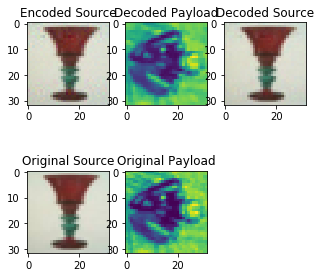

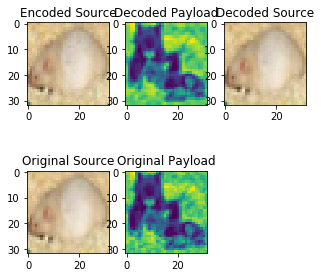

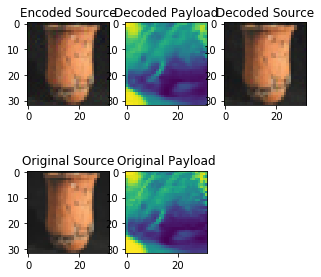

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


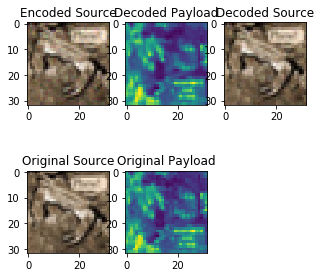

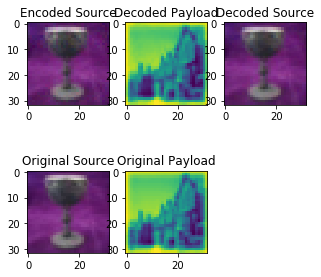

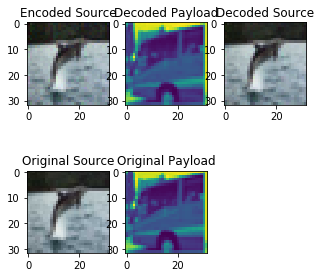

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


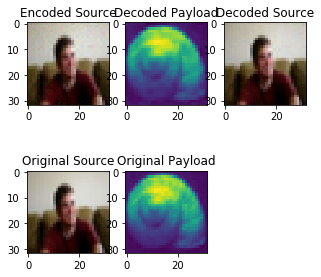

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


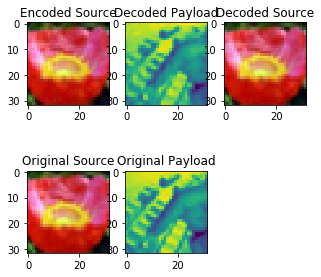

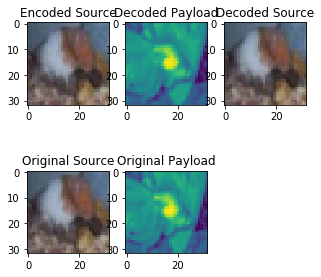

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


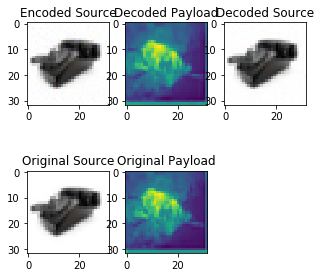

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


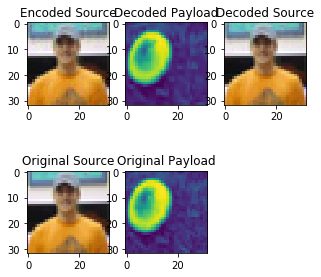

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


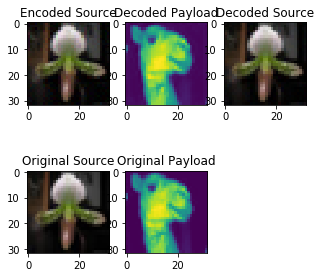

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


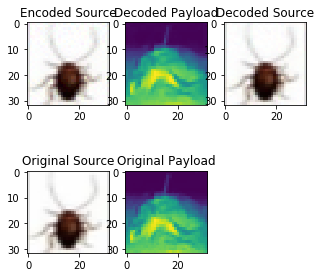

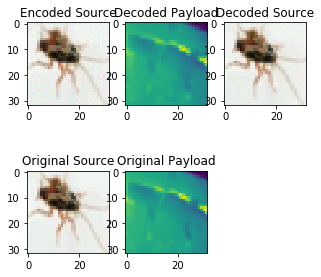

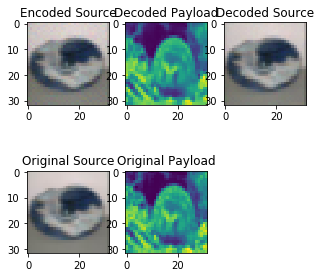

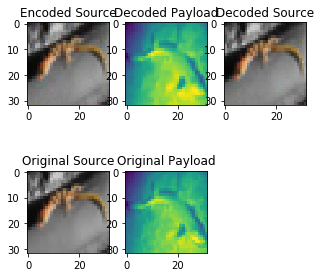

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


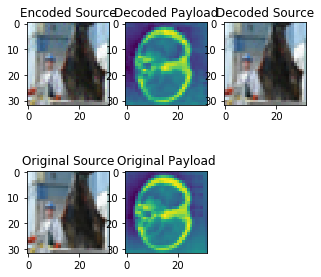

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


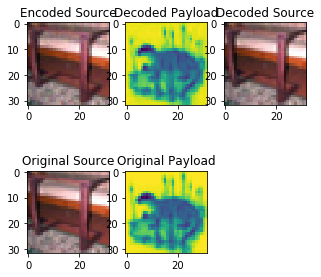

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


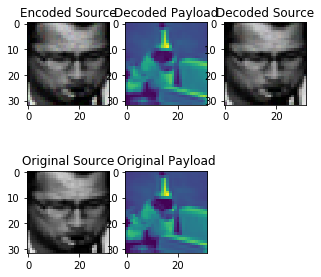

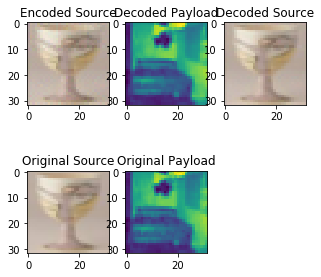

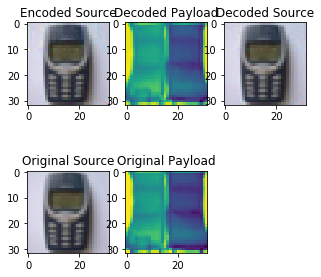

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


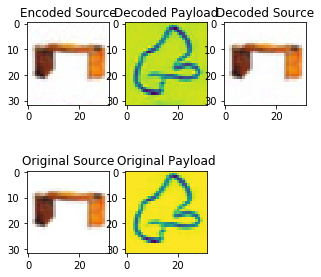

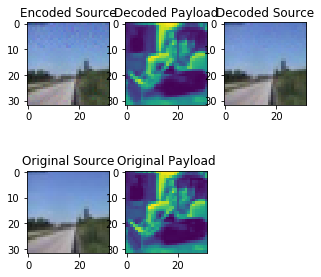

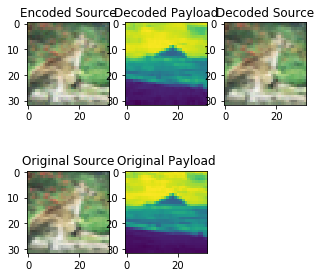

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


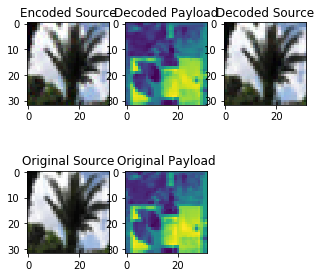

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


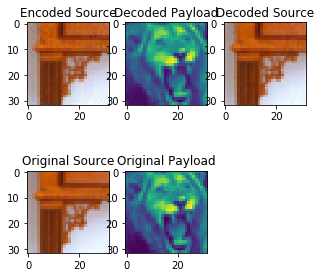

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


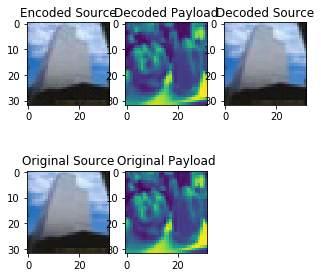

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


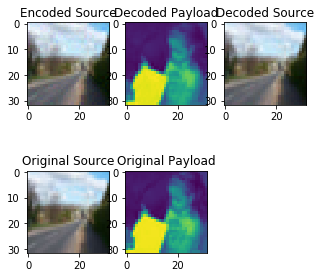

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


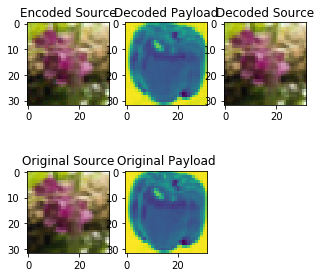

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


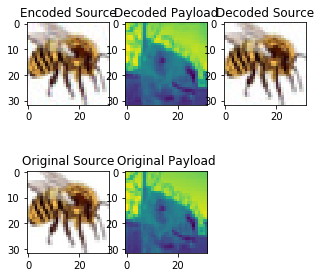

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


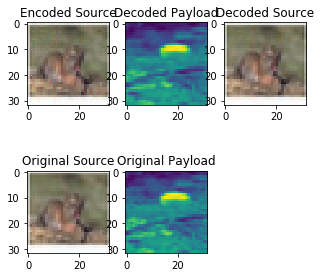

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


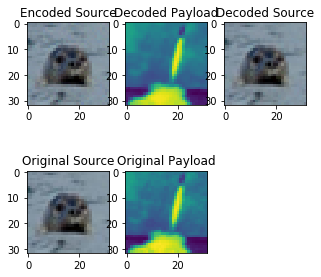

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


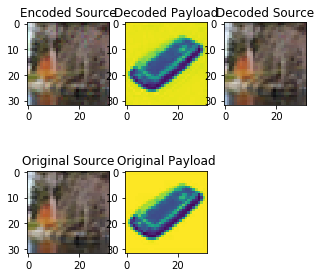

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


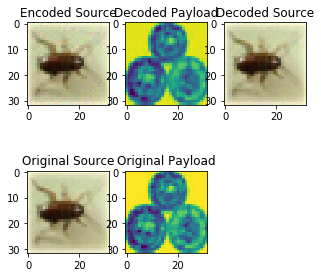

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


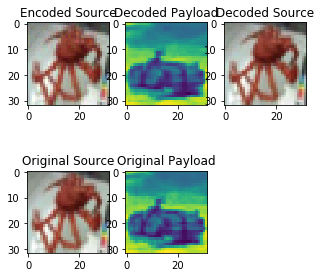

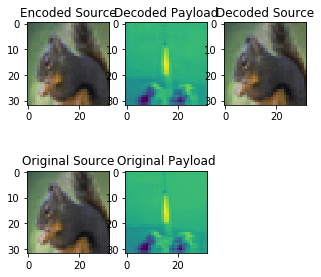

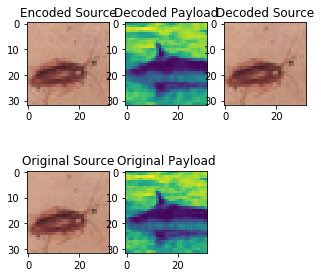

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


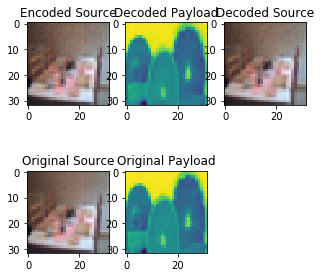

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


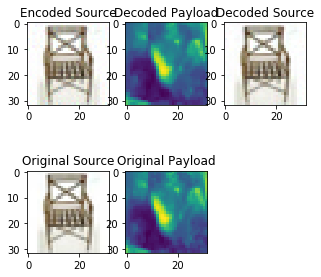

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


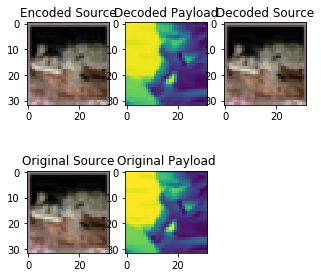

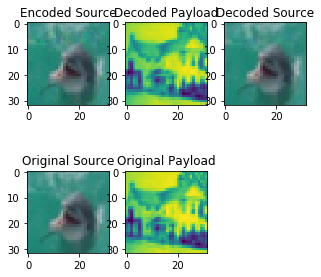

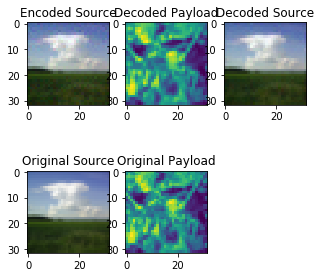

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


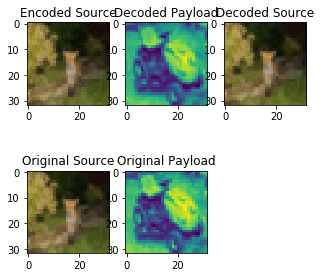

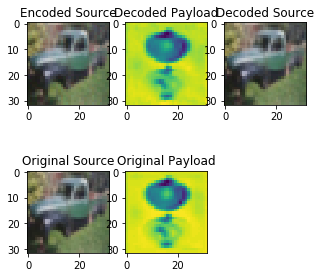

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


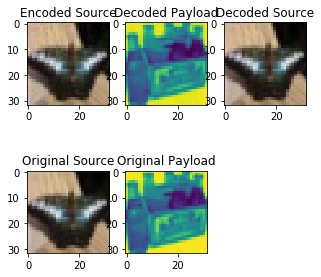

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


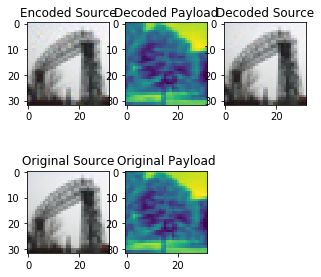

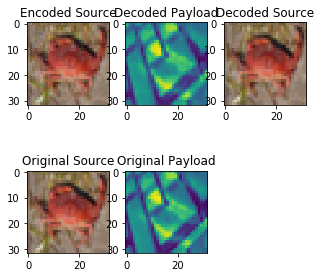

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


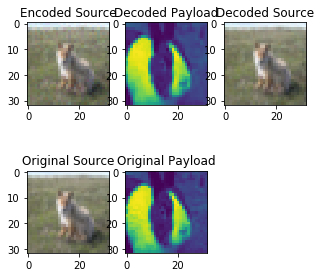

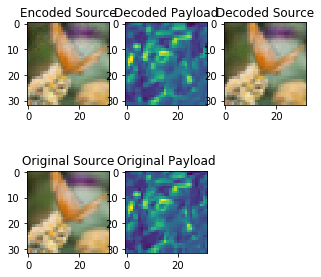

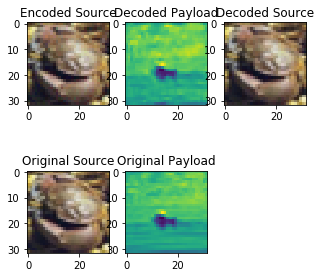

In [34]:
index = 20
encoded_psnr = []
decoded_psnr = []
for index in range(len(e)):
    eimage = e.view((-1, 32, 32, 3)).numpy()[index]
    dpimage = dp.view((-1, 32, 32)).numpy()[index]
    dsimage = ds.view((-1, 32, 32, 3)).numpy()[index]

    sourceimage, payloadimage = ss.numpy()[index], pp.numpy()[index]
    plt.figure(figsize=(5,5))
    plt.subplot(2, 3, 1)
    plt.title('Encoded Source')
    plt.imshow(eimage)
    plt.subplot(2, 3, 2)
    plt.title('Decoded Payload')
    plt.imshow(dpimage)
    plt.subplot(2, 3, 3)
    plt.title('Decoded Source')
    plt.imshow(dsimage)

    plt.subplot(2, 3, 4)
    plt.title('Original Source')
    plt.imshow(sourceimage)
    plt.subplot(2, 3, 5)
    plt.title('Original Payload')
    plt.imshow(payloadimage)
    
    plt.show()
    
    e_psnr, d_psnr = skimage.measure.compare_psnr(sourceimage, eimage), skimage.measure.compare_psnr(payloadimage, dpimage)
    encoded_psnr.append(e_psnr)
    decoded_psnr.append(d_psnr)

In [35]:
np.mean(encoded_psnr)

35.87453924216169

In [36]:
np.mean(decoded_psnr)

35.304233966654806

In [65]:
np.unique(np.sum(sourceimage, axis=-1))

array([ 28,  31,  36,  38,  40,  46,  48,  56,  57,  60,  64,  66,  68,
        69,  70,  72,  75,  77,  79,  80,  82,  84,  85,  87,  88,  89,
        92,  93,  94,  96, 101, 102, 104, 105, 106, 107, 108, 109, 111,
       113, 114, 115, 116, 119, 121, 122, 125, 127, 129, 131, 132, 134,
       136, 137, 139, 142, 144, 147, 148, 152, 156, 157, 159, 161, 162,
       163, 165, 168, 169, 172, 176, 181, 184, 186, 190, 191, 194, 195,
       197, 202, 203, 204, 207, 210, 211, 212, 213, 214, 215, 218, 219,
       220, 221, 222, 225, 227, 228, 231, 232, 233, 235, 238, 239, 240,
       241, 244, 245, 247, 248, 249, 253, 254, 255, 256, 257, 258, 260,
       261, 263, 266, 267, 268, 269, 272, 273, 275, 280, 281, 284, 285,
       287, 289, 290, 291, 292, 293, 294, 297, 298, 299, 303, 304, 306,
       309, 311, 313, 314, 315, 316, 319, 320, 323, 324, 325, 326, 329,
       330, 331, 332, 333, 335, 337, 338, 340, 341, 343, 344, 345, 347,
       349, 350, 351, 352, 353, 356, 357, 360, 362, 363, 365, 36

In [70]:
 np.sum(eimage, axis=-1)

array([[511, 254, 254, ..., 502, 251, 505],
       [505, 757, 504, ..., 504, 254, 250],
       [256, 500, 498, ..., 510, 253, 255],
       ...,
       [757, 499, 248, ..., 252, 504, 246],
       [509, 753, 501, ..., 254, 511, 493],
       [504, 508, 509, ..., 510, 504, 510]], dtype=uint64)

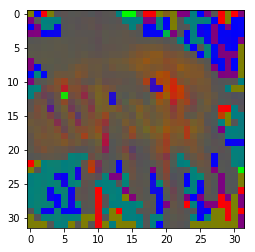

In [64]:
plt.imshow(eimage / np.sum(eimage, axis=-1).reshape((32,32,1)))

In [57]:
s.shape

torch.Size([64, 32, 32, 3])

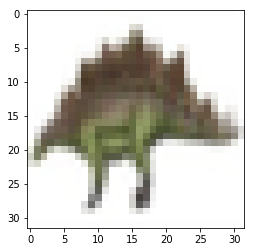

In [56]:
plt.imshow(train_x[1].reshape((3,32,32)).reshape((32,32,3)))

In [ ]:
p.shape

In [ ]:
test_loss = 0.

model.eval()
test_batches = int(len(source_test) / test_batch_size)
with torch.no_grad():
    for idx in tqdm(range(int(len(source_val) / 60))):
        s, p = source_test[idx*60: (idx * 60) + 60], payload_test[idx*60: (idx * 60) + 60]
        s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()

        e_out, d_out = model.forward((s, p))

        e_loss = metric(e_out.squeeze(1).view((-1, 28 * 28)), s.squeeze(1).view((-1, 28 * 28)))
        d_loss = metric(d_out.squeeze(1).view((-1, 28 * 28)), p.squeeze(1).view((-1, 28 * 28)))
        loss = e_loss + d_loss

        test_loss += loss

        

    with torch.no_grad():
        for idx in tqdm(range(val_batches)):
            s, p = source_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size], payload_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size]
            s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()

            e_out, d_out = model.forward((s, p))

            e_loss = metric(e_out.view((-1, flat_image_size)), s.view((-1, flat_image_size)))
            d_loss = metric(d_out.view((-1, flat_image_size)), p.view((-1, flat_image_size)))
            loss = e_loss + d_loss
    print('Test Loss: {}'.format(test_loss /int(len(source_test) / 60)))